# Supernova Data Analysis with numpyro's NUTS and emcee

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random

import jax_cosmo as jc

import numpyro
from numpyro import sample
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt

import arviz as az

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
key = random.PRNGKey(3141)
key, subkey, subkey2, subkey3 = random.split(key, 4)

### Creating random data

The distance modulus $\mu$ is given through the following equation

\begin{equation}
    25 + 5 \log_{10}\left( \frac{d_L}{\text{Mpc}} \right),
\end{equation}

where $d_L$ is the distance modulus. It is related to the angular diameter distance $d_A$ via

\begin{equation}
    d_L/\text{[Mpc]} = \frac{d_A/\text{[Mpc/h]}}{h a^2},
\end{equation}

where $d_A$ is included in jax_cosmo and returned in units of [Mpc/h].

$a$ is the universe's scale parameter and related with the redshift parameter $z$ through $a = 1/(1+z)$

In [3]:
shape = (2000,)
z_random = random.uniform(key, shape, minval=0.01, maxval=1.5)
z = jnp.sort(z_random)

In [4]:
true_param = {'h':0.7,
    'Omega_m':0.29,
    'w0':-1.02,
    'wa':0.01}

In [5]:
def distance_modulus(theta, z):
    a = jc.utils.z2a(z)
    h = theta.get('h', 0.7)
    Omega_m = theta.get('Omega_m', 0.3)
    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    Omega_k = theta.get('Omega_k', 0.)
    w0 = theta.get('w0', -1.)
    wa = theta.get('wa', 0.)
    
    cosmology = jc.Cosmology(h=h, Omega_c=Omega_c, Omega_b=Omega_b, w0=w0, wa=wa, Omega_k=Omega_k, n_s=0.96, sigma8=0.83)
    dist_L = (jc.background.angular_diameter_distance(cosmology, a)/a**2.0)/h
    dist_mod = 25. + 5. * jnp.log10(dist_L)
    return dist_mod

In [6]:
sigma = 0.3 * jnp.log(1+z)
dist_mod_err = sigma * random.normal(subkey, shape) 

cov = jnp.diag(sigma**2)

In [7]:
dist_mod = distance_modulus(true_param, z)# + dist_mod_err

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


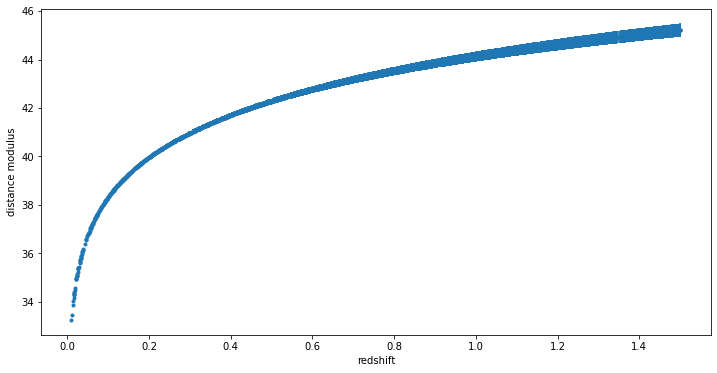

In [9]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='.', linestyle='')
plt.xlabel('redshift')
plt.ylabel('distance modulus');

### Doing Inference with NUTS

In [70]:
def model_cpl():
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    w0 = sample("w0", dist.Uniform(-10, 10))
    wa = sample("wa", dist.Uniform(-10,10))
    theta_dict = {"Omega_m":Omega_m, "w0":w0, "wa":wa}
    mu = distance_modulus(theta_dict, z)
    
    return sample("y", dist.MultivariateNormal(mu, cov), obs=dist_mod)


In [89]:
mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model_cpl, 
              step_size=1e-1, 
              init_strategy=numpyro.infer.init_to_median, 
              dense_mass=True, 
              max_tree_depth=5
             )
mcmc = MCMC(kernel, 
            num_warmup=500, 
            num_samples=5000, 
            num_chains=16, 
            chain_method='vectorized'
           )
mcmc.run(subkey2)

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
  0%|                                                                         

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


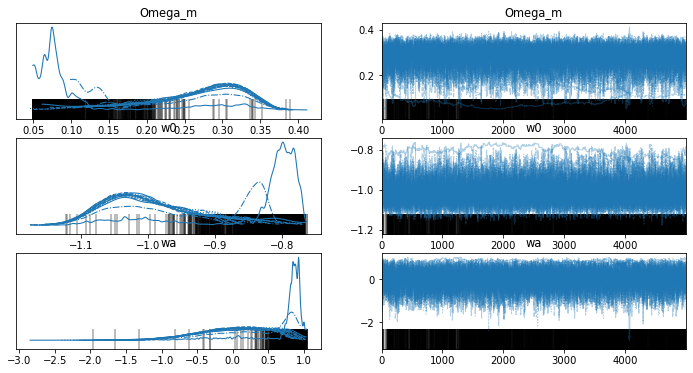

In [90]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata);

In [104]:
jnp.mean(idata.posterior["Omega_m"].values, axis=-1)

DeviceArray([0.25609833, 0.27234116, 0.2651288 , 0.2754805 , 0.28279075,
             0.27430028, 0.27845785, 0.26893163, 0.28064293, 0.2623039 ,
             0.26605985, 0.22047864, 0.11635671, 0.26907155, 0.28257486,
             0.2697295 ], dtype=float32)

In [105]:
idata_sel = idata.sel(chain=[0,1,2,3,4,5,6,7,8,9,10,11,13,14,15])

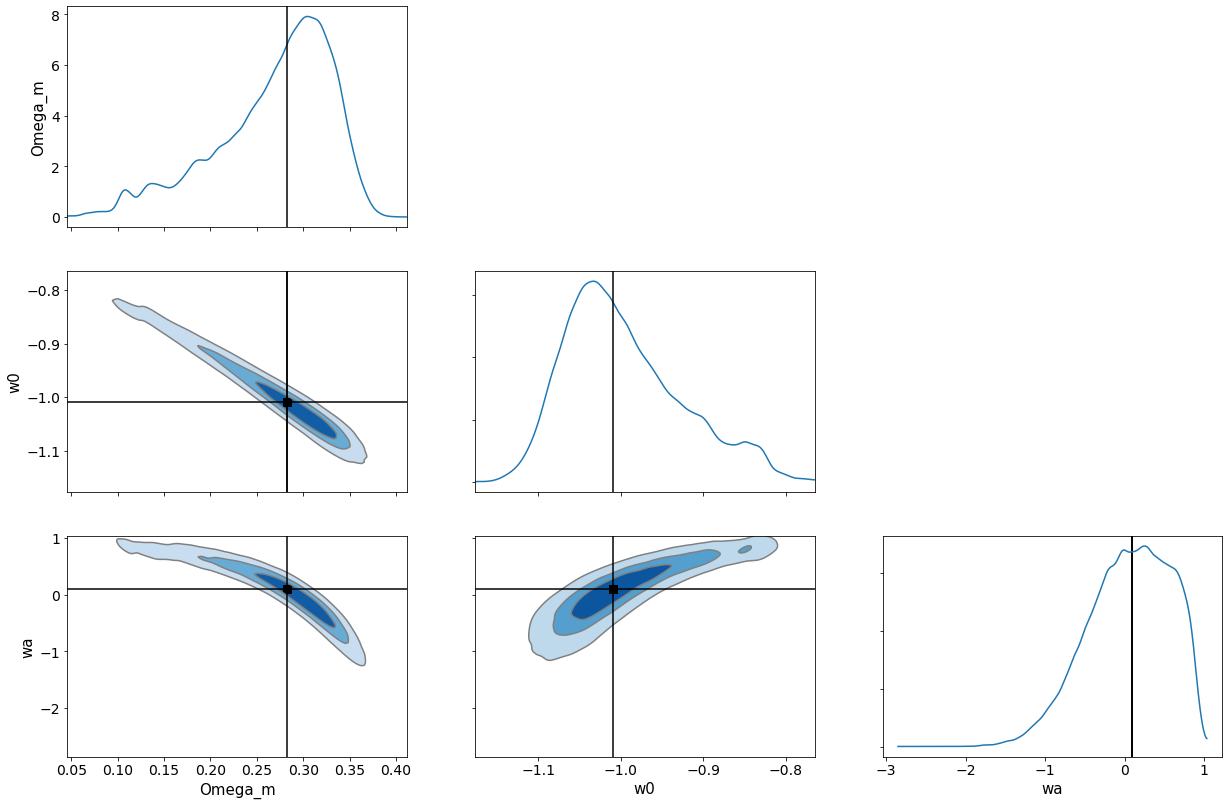

In [107]:
az.plot_pair(idata_sel.sel(), 
             kind = "kde", 
             kde_kwargs={
                 "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
                 "contourf_kwargs": {"cmap": "Blues"}}, 
             point_estimate='median',
             marginals=True,
            );

In [108]:
az.summary(idata_sel)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Omega_m,0.268,0.062,0.138,0.364,0.005,0.004,213.0,55.0,1.05
w0,-0.997,0.071,-1.108,-0.847,0.006,0.004,216.0,59.0,1.04
wa,0.051,0.517,-0.860,0.906,0.025,0.018,243.0,131.0,1.04


# emcee

In [10]:
import emcee as em
import numpy as np

In [11]:
inv_cov = jnp.linalg.inv(cov)

Defining the joint probability.

In [12]:
def log_likelihood(theta_dict):
    distance_mod = np.asarray(distance_modulus(theta_dict, z) , dtype=float)
    log_like = -0.5 * ((dist_mod - distance_mod) @ inv_cov @ (dist_mod - distance_mod))
    return log_like

In [13]:
def log_prior(Omega_m=0.3, w_0=-1, w_1=0):
    '''returns the log of the propability densities up to a constant'''
    if 0.0 < Omega_m < 1.0:
        return -((w_0+1.0)**2.0/5.0**2.0 + (w_1)**2.0/5.0**2.0) 
    return -np.inf

In [14]:
def log_probability(theta):
    '''performs the multiplication prior*likelihood'''
    keys = ['Omega_m', 'w_0', 'w_1']
    theta_dict = dict(zip(keys, theta))
    lp = log_prior(**theta_dict)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta_dict)

### Running the optimizer

In [15]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [17]:
#print(name+' started...')
nwalkers = 8
initial = [0.3, -1, 0.01]
ndim = 3
pos = initial + 0.05 * np.random.randn(nwalkers, ndim) 

sampler = em.EnsembleSampler(
nwalkers, ndim, log_probability#, backend=backend
)
sampler.run_mcmc(pos, 1000, progress=True)
samples = sampler.get_chain(flat=True)   

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [34:54<00:00,  2.09s/it]


In [23]:
var_names = ['Omega_m', 'w0', 'wa']
idata_em = az.from_emcee(sampler, var_names=var_names)

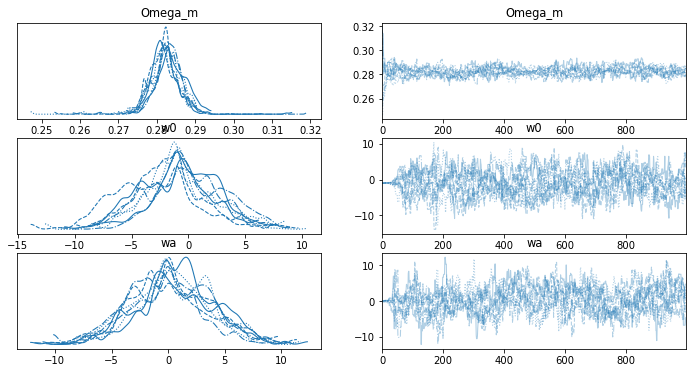

In [24]:
az.plot_trace(idata_em);

In [25]:
az.summary(idata_em)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Omega_m,0.282,0.004,0.276,0.290,0.000,0.000,159.0,395.0,1.05
w0,-1.001,3.379,-7.300,5.541,0.321,0.228,108.0,237.0,1.08
wa,0.298,3.482,-6.222,6.834,0.294,0.208,140.0,594.0,1.05


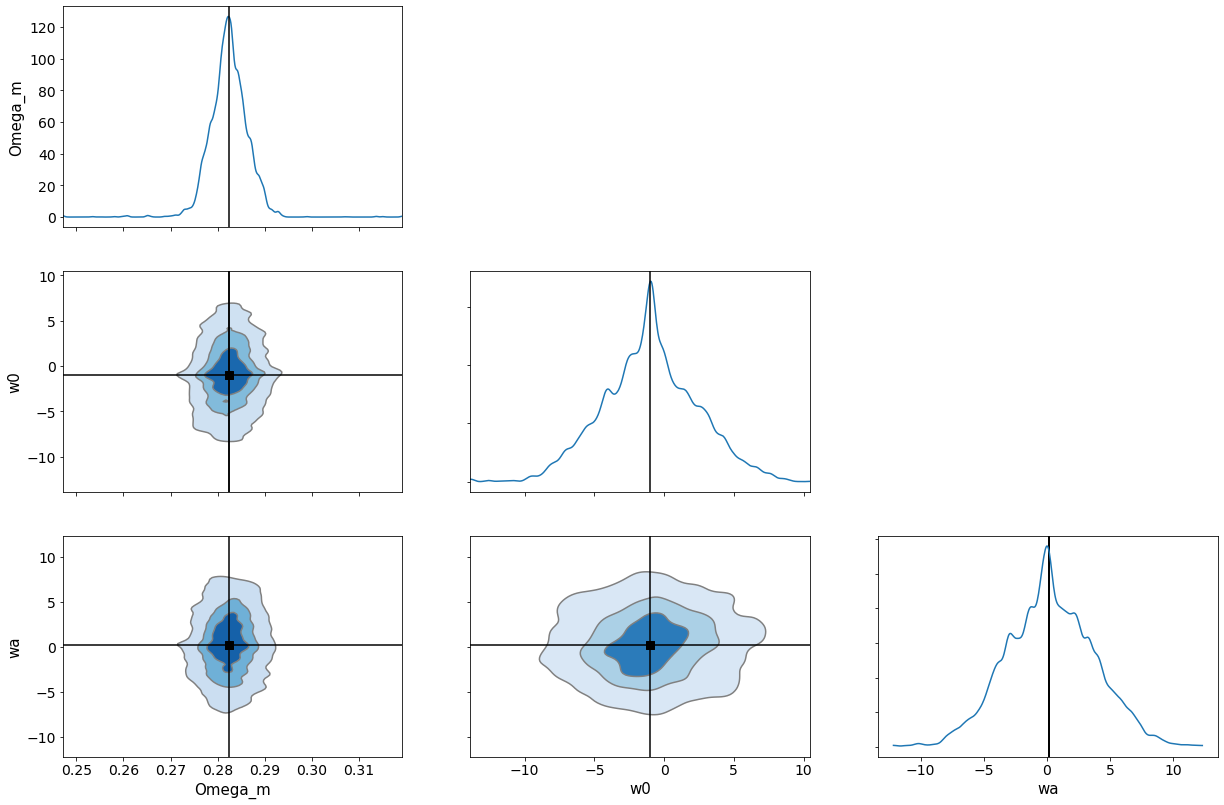

In [26]:
az.plot_pair(idata_em, 
             kind = "kde", 
             kde_kwargs={
                 "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
                 "contourf_kwargs": {"cmap": "Blues"}}, 
             point_estimate='median',
             marginals=True,
            );